In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from costs import *

def least_squares_for_nonsingular_gram(y, tx):
    """calculate the least squares solution."""
    gram = (tx.T).dot(tx)
    inv_gram = np.linalg.inv(gram)
    w_star = (inv_gram.dot(tx.T)).dot(y)
    mse = compute_loss(y, tx, w_star)
    return mse, w_star

In [3]:
import datetime
from helpers import *

def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    # Start gradient descent.
    start_time = datetime.datetime.now()
    mse, w_star = least_squares_for_nonsingular_gram(y, tx)
    end_time = datetime.datetime.now()

    # Print result
    print("Least squares: loss={l}, w0={w0}, w1={w1}".format(l=mse, w0=w_star[0], w1=w_star[1]))
    execution_time = (end_time - start_time).total_seconds()
    print("Least squares: execution time={t:.3f} seconds".format(t=execution_time))

In [4]:
test_your_least_squares()

Least squares: loss=15.385887868829398, w0=73.29392200210519, w1=13.479712434989061
Least squares: execution time=0.192 seconds


In [5]:
# load dataset dataEx3.csv
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [6]:
from build_polynomial import build_poly

In [7]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w_star = np.linalg.solve((tx.T).dot(tx), (tx.T).dot(y))
    rmse = compute_rmse_loss(y, tx, w_star)
    return rmse, w_star

In [8]:
from plots import *

def polynomial_regression(): 
    
    """Constructing the polynomial basis function expansion of the data, and then running least squares regression."""

    # define parameters
    degrees = [1, 3, 7, 12]

    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):

        # form the data to do polynomial regression.
        tx = build_poly(x, degree)

        # least square and calculate RMSE:
        rmse, weights = least_squares(y, tx)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.2585827766773751
Processing 3th experiment, degree=7, rmse=0.24965870360907413
Processing 4th experiment, degree=12, rmse=0.24536446909197063


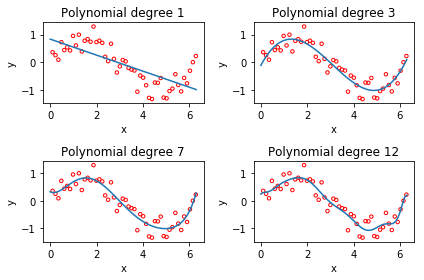

In [9]:
polynomial_regression()

In [10]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    
    # split the data based on the given ratio
    N = y.shape[0]
    train_N = int(np.floor(N * ratio))
    ind = np.random.choice(N, train_N, False)
    
    x_train = np.take(x, ind)
    y_train = np.take(y, ind)
    x_test = np.delete(x, ind)
    y_test = np.delete(y, ind)
    return x_train, y_train, x_test, y_test

In [11]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    
    # split the data, and return train and test data
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)
    
    # form train and test data with polynomial basis function
    tx_train = build_poly(x_train, degree)
    tx_test = build_poly(x_test, degree)
    # calcualte weight through least square.
    rmse, weights = least_squares(y_train, tx_train)

    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively
    rmse_tr = compute_rmse_loss(y_train, tx_train, weights)
    rmse_te = compute_rmse_loss(y_test, tx_test, weights)
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))

In [12]:
seed = 6
degrees = [1, 3, 7, 12]

split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)
    print("------------------------------------------------------------------")

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.250
------------------------------------------------------------------
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.466
------------------------------------------------------------------
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.254
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=4.651
------------------------------------------------------------------


In [13]:
### -----
### Ridge Regression

In [14]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    N = y.shape[0]
    D = tx.shape[1]
    lambda_dash = 2 * N * lambda_
    coefficient = np.add((tx.T).dot(tx), lambda_dash * np.identity(D))
    w_star = np.linalg.solve(coefficient, (tx.T).dot(y))
    return w_star

In [15]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    
    # split the data, and return train and test data
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)
    
    # form train and test data with polynomial basis function
    tx_train = build_poly(x_train, degree)
    tx_test = build_poly(x_test, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        
        # ridge regression with a given lambda
        w_star = ridge_regression(y_train, tx_train, lambda_)
        rmse_tr.append(compute_rmse_loss(y_train, tx_train, w_star))
        rmse_te.append(compute_rmse_loss(y_test, tx_test, w_star))
        
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.193, 

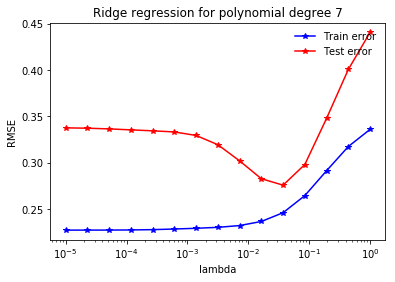

In [16]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)